### 데이콘 Basic 풍속 예측 AI 경진대회

- https://dacon.io/competitions/official/236126/data

- 57920개의 데이터

- ID : 샘플 별 고유 id

- 월: 데이터가 기록된 달을 나타냅니다.

- 일: 데이터가 기록된 날짜를 나타냅니다.

- 측정 시간대: 데이터가 측정된 시간대를 나타냅니다. 오전, 오후,
저녁, 새벽으로 구분되어 있습니다.

- 섭씨 온도 (° ⁣C)

- 절대 온도 (K)

- 이슬점 온도 (° ⁣C)

- 상대 습도 (%)

- 대기압 (mbar)

- 포화 증기압 (mbar)

- 실제 증기압 (mbar)

- 증기압 부족량 (mbar)

- 수증기 함량 (g/kg): 공기 1 kg당 수증기의 질량을 그램(g) 단위로 나타냅니다.

- 공기 밀도 (g/m**3): 1 m³의 부피에 들어있는 공기의 질량을 그램(g) 단위로 나타냅니다.

- 풍향 (deg): 바람의 향하는 방향을 각도(degree)로 나타냅니다.

- 풍속 (m/s): target값

#### 라이브러리 정의

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import random
from scipy.stats import skew

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

#from autogluon.tabular import TabularDataset, TabularPredictor
#import autogluon.core as ag

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

#### 데이터 불러오기, 탐색

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
train.head()

,ID,월,일,측정 시간대,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg),풍속 (m/s)
0,TRAIN_00000,7,2,저녁,13.97,287.78,9.84,76.1,992.08,15.98,12.16,3.82,7.66,1198.06,155.60,1.61
1,TRAIN_00001,8,21,오전,16.94,290.85,12.14,73.3,991.07,19.33,14.17,5.16,8.94,1183.67,177.00,1.68
2,TRAIN_00002,11,1,저녁,9.76,283.84,5.40,74.2,988.71,12.10,8.98,3.12,5.67,1213.22,146.20,0.73
3,TRAIN_00003,12,28,오전,5.27,277.30,2.71,83.5,1014.25,8.89,7.43,1.47,4.57,1265.48,264.50,2.71
4,TRAIN_00004,9,26,오후,17.35,290.86,12.68,74.0,995.77,19.84,14.68,5.16,9.22,1187.40,19.34,1.00


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36581 entries, 0 to 36580
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              36581 non-null  object 
 1   월               36581 non-null  int64  
 2   일               36581 non-null  int64  
 3   측정 시간대          36581 non-null  object 
 4   섭씨 온도(°⁣C)      36581 non-null  float64
 5   절대 온도(K)        36581 non-null  float64
 6   이슬점 온도(°C)      36581 non-null  float64
 7   상대 습도 (%)       36581 non-null  float64
 8   대기압(mbar)       36581 non-null  float64
 9   포화 증기압(mbar)    36581 non-null  float64
 10  실제 증기압(mbar)    36581 non-null  float64
 11  증기압 부족량(mbar)   36581 non-null  float64
 12  수증기 함량 (g/kg)   36581 non-null  float64
 13  공기 밀도 (g/m**3)  36581 non-null  float64
 14  풍향 (deg)        36581 non-null  float64
 15  풍속 (m/s)        36581 non-null  float64
dtypes: float64(12), int64(2), object(2)
memory usage: 4.5+ MB


In [ ]:
test.head()

,ID,월,일,측정 시간대,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg)
0,TEST_00000,3,24,새벽,4.28,278.68,-0.21,72.5,984.48,8.30,6.02,2.28,3.81,1233.29,251.80
1,TEST_00001,9,24,저녁,13.40,286.81,10.36,81.8,996.98,15.40,12.59,2.80,7.89,1206.20,225.60
2,TEST_00002,5,28,저녁,19.89,294.33,14.95,73.2,984.83,23.26,17.03,6.23,10.82,1163.06,10.39
3,TEST_00003,1,17,저녁,-2.88,270.44,-4.47,88.7,998.02,4.94,4.38,0.56,2.73,1284.19,260.20
4,TEST_00004,10,22,오후,6.97,281.18,4.36,83.4,987.00,10.01,8.35,1.66,5.28,1223.47,262.50


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15678 entries, 0 to 15677
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              15678 non-null  object 
 1   월               15678 non-null  int64  
 2   일               15678 non-null  int64  
 3   측정 시간대          15678 non-null  object 
 4   섭씨 온도(°⁣C)      15678 non-null  float64
 5   절대 온도(K)        15678 non-null  float64
 6   이슬점 온도(°C)      15678 non-null  float64
 7   상대 습도 (%)       15678 non-null  float64
 8   대기압(mbar)       15678 non-null  float64
 9   포화 증기압(mbar)    15678 non-null  float64
 10  실제 증기압(mbar)    15678 non-null  float64
 11  증기압 부족량(mbar)   15678 non-null  float64
 12  수증기 함량 (g/kg)   15678 non-null  float64
 13  공기 밀도 (g/m**3)  15678 non-null  float64
 14  풍향 (deg)        15678 non-null  float64
dtypes: float64(11), int64(2), object(2)
memory usage: 1.8+ MB


train, test 모두 결측치 없음

In [ ]:
train.describe()

,월,일,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg),풍속 (m/s)
count,36581.000000,36581.000000,36581.000000,36581.000000,36581.000000,36581.000000,36581.000000,36581.000000,36581.000000,36581.000000,36581.000000,36581.000000,36581.00000,36581.000000
mean,6.511468,15.648561,9.992694,283.971095,5.453064,75.827418,990.032953,14.037167,9.786895,4.250224,6.178010,1214.580682,176.58240,2.036446
std,3.458678,8.803467,8.237177,8.354235,6.327009,16.089188,8.824477,8.075680,4.185701,5.191128,2.655054,39.528520,84.38269,1.544146
min,1.000000,1.000000,-13.930000,258.870000,-15.560000,23.640000,956.890000,2.070000,1.810000,0.000000,1.120000,1110.650000,0.01000,0.100000
25%,4.000000,8.000000,3.650000,277.700000,0.450000,65.360000,985.100000,7.940000,6.310000,0.950000,3.980000,1184.030000,129.40000,0.920000
50%,7.000000,16.000000,9.130000,283.170000,5.070000,79.000000,990.250000,11.590000,8.770000,2.250000,5.520000,1214.650000,199.50000,1.630000
75%,9.000000,23.000000,16.350000,290.370000,10.950000,89.200000,995.700000,18.620000,13.100000,5.410000,8.270000,1241.600000,233.90000,2.700000
max,12.000000,31.000000,34.340000,308.620000,20.150000,100.000000,1015.300000,54.270000,23.640000,41.230000,14.980000,1349.460000,360.00000,11.890000


In [ ]:
train.corr()

,월,일,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg),풍속 (m/s)
월,1.000000,-0.004106,0.150799,0.113863,0.225914,0.086025,0.414791,0.138394,0.210962,0.045196,0.204353,-0.028760,0.009146,-0.186495
일,-0.004106,1.000000,0.036927,0.022892,0.034864,-0.021352,0.160538,0.050455,0.051187,0.037222,0.048915,0.011268,0.044461,0.031513
섭씨 온도(°⁣C),0.150799,0.036927,1.000000,0.996372,0.896195,-0.624135,-0.094014,0.962549,0.877030,0.790244,0.876737,-0.958652,0.016658,0.098497
절대 온도(K),0.113863,0.022892,0.996372,1.000000,0.893198,-0.622665,-0.178365,0.956424,0.872587,0.784298,0.873683,-0.979099,0.022562,0.114711
이슬점 온도(°C),0.225914,0.034864,0.896195,0.893198,1.000000,-0.222133,-0.087869,0.812883,0.981239,0.473384,0.980871,-0.875042,0.016848,-0.048942
상대 습도 (%),0.086025,-0.021352,-0.624135,-0.622665,-0.222133,1.000000,0.067025,-0.659667,-0.212495,-0.854891,-0.212696,0.577811,-0.027953,-0.321123
대기압(mbar),0.414791,0.160538,-0.094014,-0.178365,-0.087869,0.067025,1.000000,-0.058629,-0.067328,-0.036927,-0.083381,0.370414,-0.071336,-0.200326
포화 증기압(mbar),0.138394,0.050455,0.962549,0.956424,0.812883,-0.659667,-0.058629,1.000000,0.825225,0.890279,0.824863,-0.904433,-0.012436,0.093631
실제 증기압(mbar),0.210962,0.051187,0.877030,0.872587,0.981239,-0.212495,-0.067328,0.825225,1.000000,0.477460,0.999841,-0.848729,0.004169,-0.073563
증기압 부족량(mbar),0.045196,0.037222,0.790244,0.784298,0.473384,-0.854891,-0.036927,0.890279,0.477460,1.000000,0.477025,-0.722655,-0.022698,0.204976


풍속과 유의미한 상관성을 보이는 피처가 없음

#### EDA

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 8 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,597 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120493 files and direc

In [ ]:
plt.rc('font', family='NanumBarunGothic')

<Axes: >

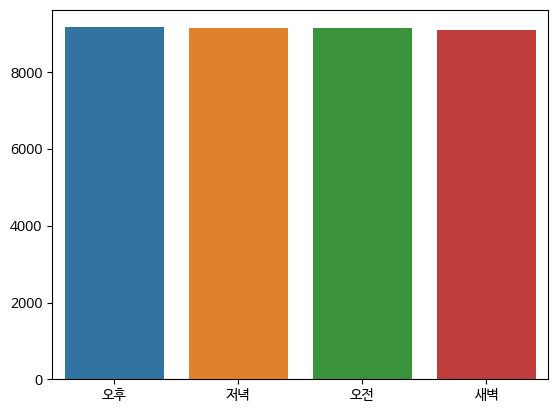

In [ ]:
time = train['측정 시간대'].value_counts()
sns.barplot(y=time.values, x=time.index)

<Axes: >

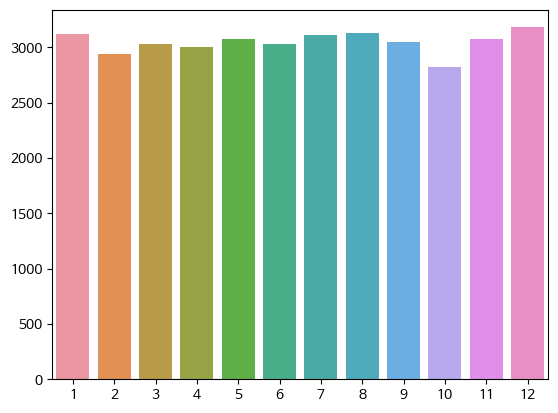

In [ ]:
month = train['월'].value_counts()
sns.barplot(x=month.index, y=month.values)

<Axes: >

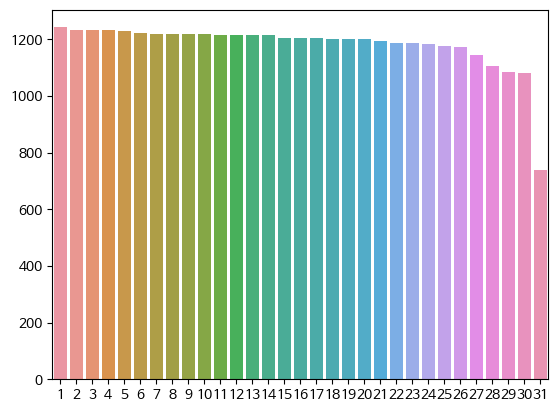

In [ ]:
day = train['일'].value_counts()
sns.barplot(y=day.values, x = day.index.sort_values())

<Axes: xlabel='풍속 (m/s)', ylabel='섭씨 온도(°\u2063C)'>

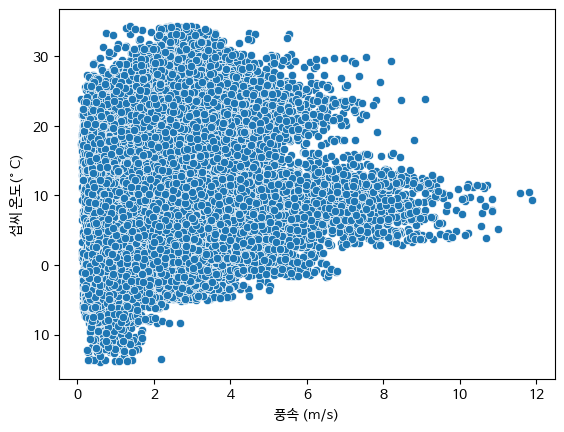

In [ ]:
sns.scatterplot(data=train, y='섭씨 온도(°⁣C)', x='풍속 (m/s)')

<Axes: xlabel='풍속 (m/s)', ylabel='절대 온도(K)'>

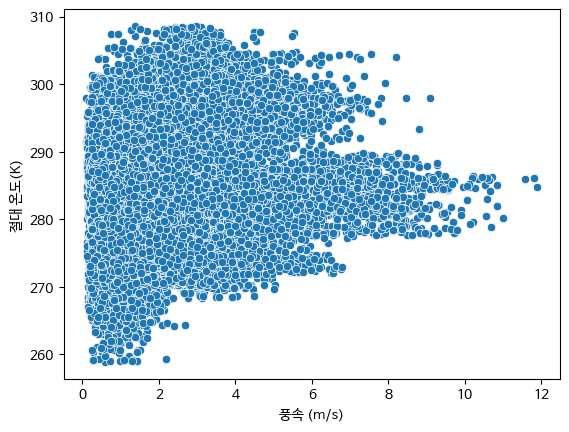

In [ ]:
sns.scatterplot(data=train, y='절대 온도(K)', x='풍속 (m/s)')

<Axes: xlabel='풍속 (m/s)', ylabel='이슬점 온도(°C)'>

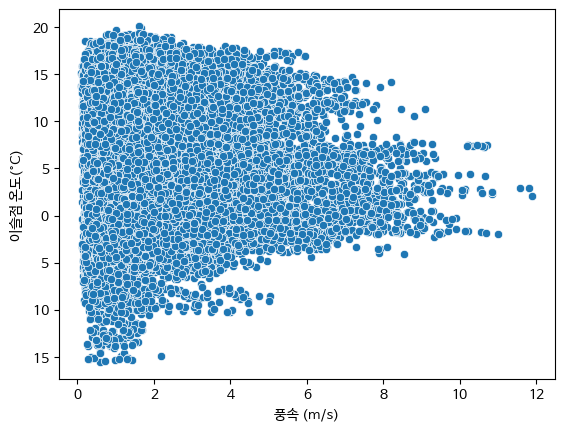

In [ ]:
sns.scatterplot(data=train, y='이슬점 온도(°C)', x='풍속 (m/s)')

<Axes: xlabel='풍속 (m/s)', ylabel='상대 습도 (%)'>

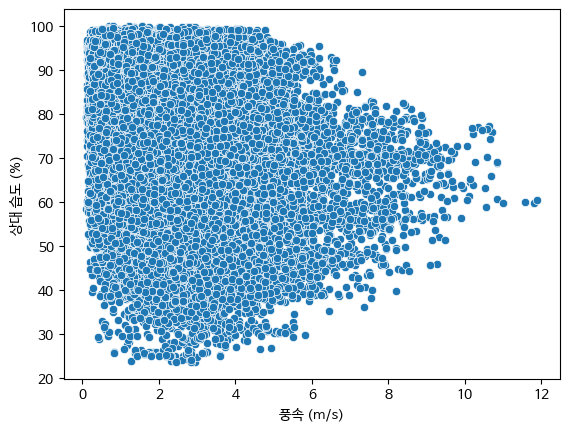

In [ ]:
sns.scatterplot(data=train, y='상대 습도 (%)', x='풍속 (m/s)')

<Axes: xlabel='풍속 (m/s)', ylabel='대기압(mbar)'>

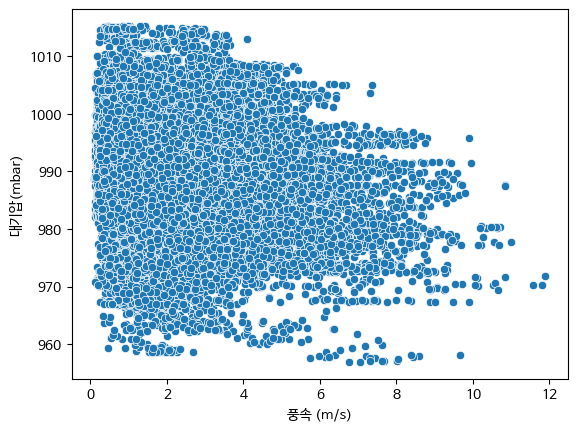

In [ ]:
sns.scatterplot(data=train, y='대기압(mbar)', x='풍속 (m/s)')

<Axes: xlabel='풍속 (m/s)', ylabel='포화 증기압(mbar)'>

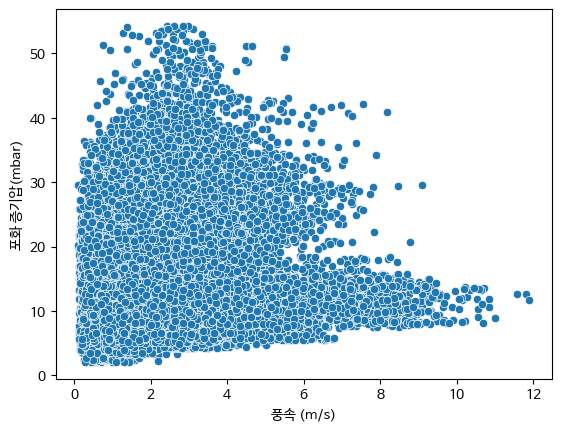

In [ ]:
sns.scatterplot(data=train, y='포화 증기압(mbar)', x='풍속 (m/s)')

<Axes: xlabel='풍속 (m/s)', ylabel='실제 증기압(mbar)'>

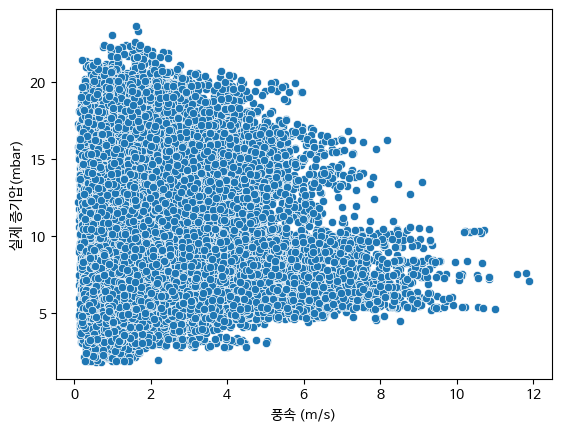

In [ ]:
sns.scatterplot(data=train, y='실제 증기압(mbar)', x='풍속 (m/s)')

<Axes: xlabel='풍속 (m/s)', ylabel='실제 증기압(mbar)'>

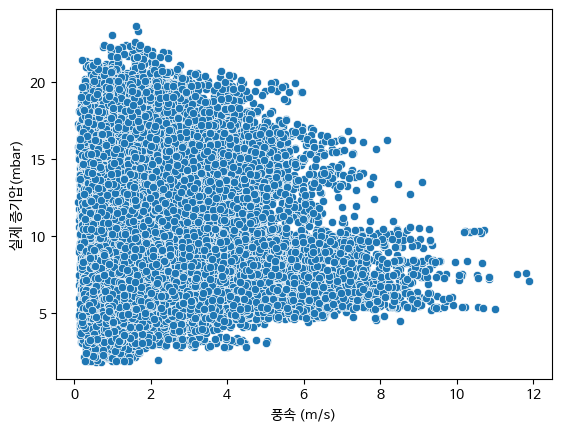

In [ ]:
sns.scatterplot(data=train, y='실제 증기압(mbar)', x='풍속 (m/s)')

<Axes: xlabel='풍속 (m/s)', ylabel='수증기 함량 (g/kg)'>

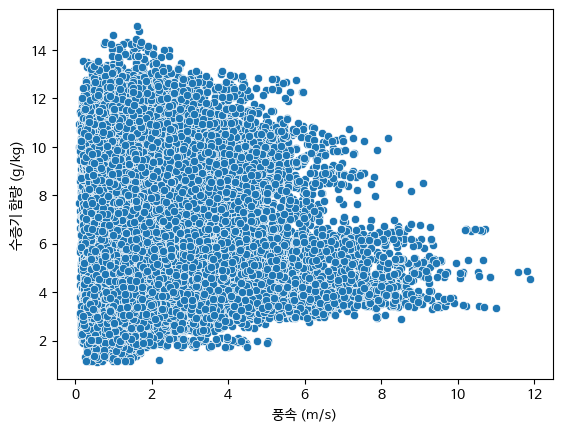

In [ ]:
sns.scatterplot(data=train, y='수증기 함량 (g/kg)', x='풍속 (m/s)')

<Axes: xlabel='풍속 (m/s)', ylabel='공기 밀도 (g/m**3)'>

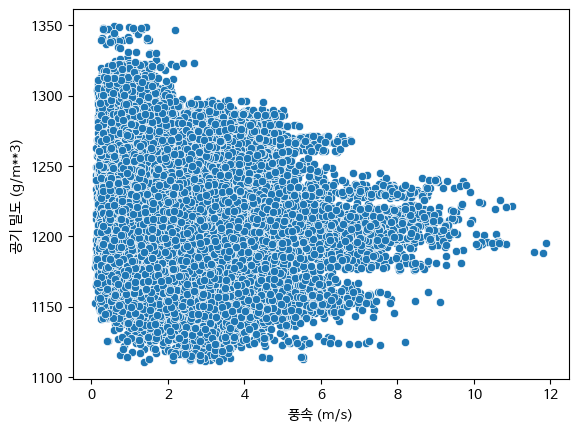

In [ ]:
sns.scatterplot(data=train, y='공기 밀도 (g/m**3)', x='풍속 (m/s)')

<Axes: xlabel='풍속 (m/s)', ylabel='풍향 (deg)'>

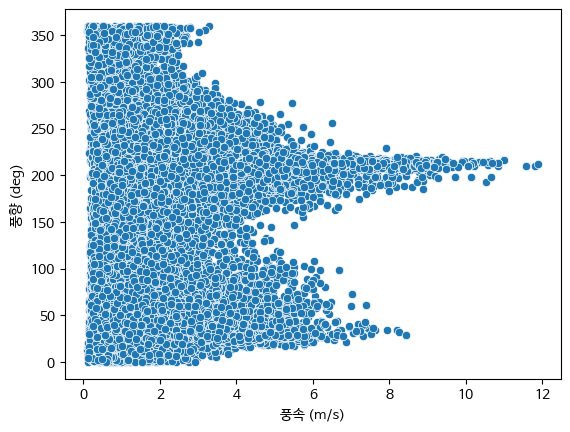

In [ ]:
sns.scatterplot(data=train, y='풍향 (deg)', x='풍속 (m/s)')

타겟값인 '풍속 (m/s)'와 이슬점 온도(°C),	상대 습도 (%),	대기압(mbar), 	포화 증기압(mbar),	실제 증기압(mbar),	증기압 부족량(mbar),	수증기 함량 (g/kg),	공기 밀도 (g/m**3),	풍향 (deg)의 산점도는 비슷한 모양을 띈다.

이상치라고 할만한 데이터는 없다고 판단

#### 전처리

- 타겟값 분포도 살펴보기 → 로그 변환

<Axes: xlabel='풍속 (m/s)', ylabel='Count'>

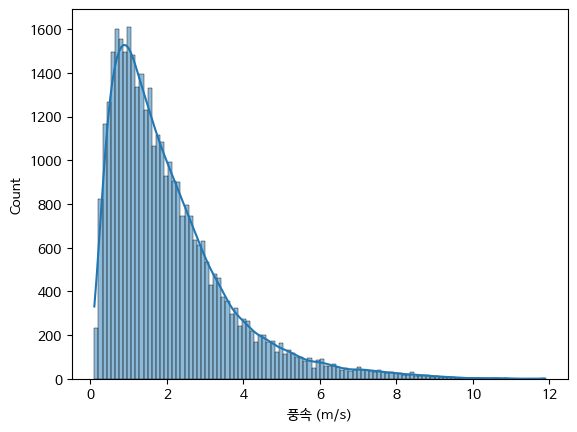

In [ ]:
sns.histplot(train['풍속 (m/s)'], kde=True)

<Axes: xlabel='풍속 (m/s)', ylabel='Count'>

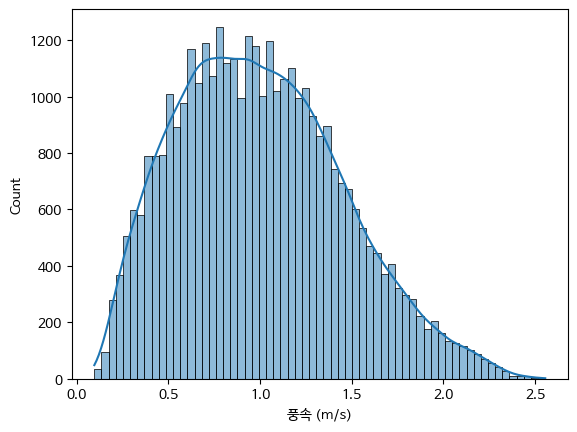

In [ ]:
log = np.log1p(train['풍속 (m/s)'])
sns.histplot(log, kde=True)

- 숫자형 피처들 분포도 살펴보기 → 왜곡 정도가 높은 피처들 로그 변환

In [ ]:
features = train.dtypes[train.dtypes != 'object'].index

skew_features = train[features].apply(lambda x : skew(x))

#skew 정도가 1 이상인 칼럼만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

증기압 부족량(mbar)    2.374898
풍속 (m/s)         1.624866
포화 증기압(mbar)     1.287343
dtype: float64


In [ ]:
train[skew_features_top.index] = np.log1p(train[skew_features_top.index])

In [ ]:
features2 = test.dtypes[test.dtypes != 'object'].index

skew_features2 = test[features2].apply(lambda x : skew(x))

#skew 정도가 1 이상인 칼럼만 추출
skew_features_top2 = skew_features2[skew_features2 > 1]
print(skew_features_top2.sort_values(ascending=False))

증기압 부족량(mbar)    2.280276
포화 증기압(mbar)     1.252155
dtype: float64


In [ ]:
test[skew_features_top2.index] = np.log1p(test[skew_features_top2.index])

- object형 피처 라벨 인코딩

In [ ]:
col = ['측정 시간대']

for i in col:
    encoder = LabelEncoder()
    encoder.fit(train[i])
    train[i] = encoder.transform(train[i])

for i in col:
    encoder = LabelEncoder()
    encoder.fit(test[i])
    test[i] = encoder.transform(test[i])

- StandardScaler 표준 정규화 → 데이터셋에 이상치가 있다면 적절하지 않지만 별다른 이상치가 있다고 판단하지 않았으므로 적용

In [ ]:
#데이터 나누고 정규화하자
X_train = train.drop(['ID', '풍속 (m/s)'], axis=1)
y_train = train['풍속 (m/s)']
X_test = test.drop('ID', axis=1)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
train_scaled = scaler.transform(X_train)

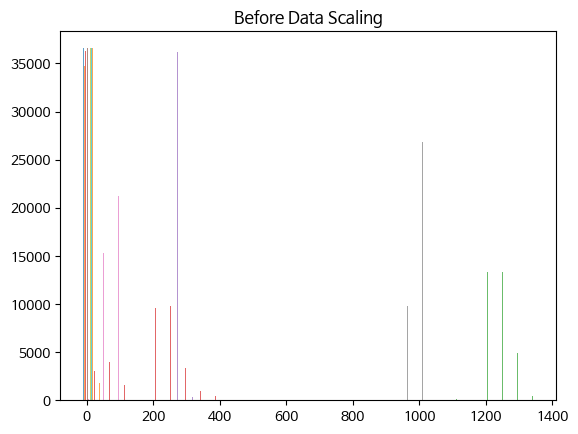

In [ ]:
#스케일링 전에 훈련용 데이터 분포
plt.hist(X_train, bins=30, alpha=0.7)
plt.title('Before Data Scaling')
plt.show()

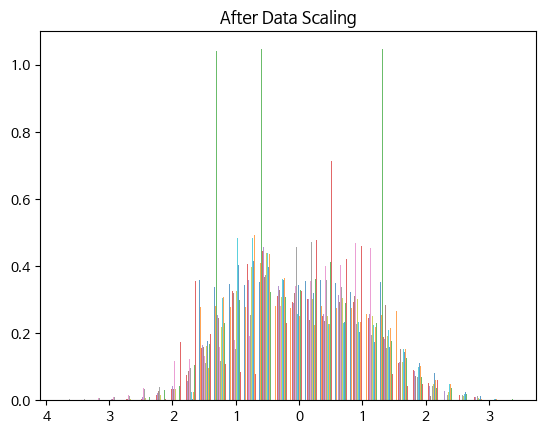

In [ ]:
#스케일링 후 훈련용 데이터 분포
plt.hist(train_scaled, bins=30, alpha=0.7, density=True)
plt.title('After Data Scaling')
plt.show()

그래프가 0을 중심으로 정규 분포 모양

In [ ]:
scaler.fit(X_test)
test_scaled = scaler.transform(X_test)

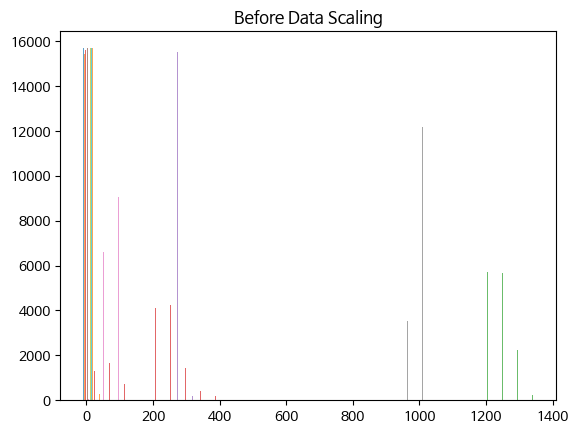

In [ ]:
#스케일링 전에 테스트용 데이터 분포
plt.hist(X_test, bins=30, alpha=0.7)
plt.title('Before Data Scaling')
plt.show()

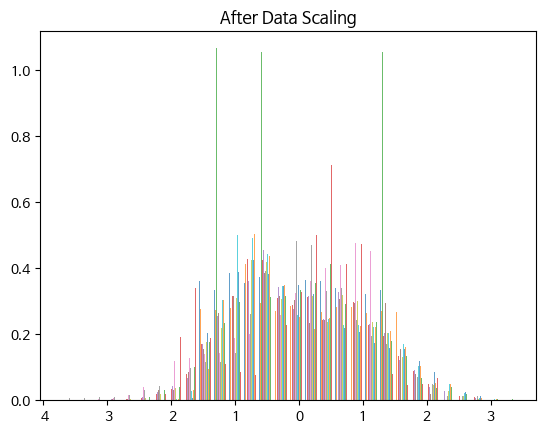

In [ ]:
#스케일링 후 테스트용 데이터 분포
plt.hist(test_scaled, bins=30, alpha=0.7, density=True)
plt.title('After Data Scaling')
plt.show()

#### 모델링 1

- 회귀 트리, XGBRegressor와 LGBMRegressor를 혼합한 모델

- 두 트리의 최적 하이퍼 파라미터 튜닝

In [ ]:
X_train_1 = X_train.copy()
y_train_1 = y_train.copy()

In [ ]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6,
                         colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

xgb_reg.fit(X_train_1, y_train_1)
lgbm_reg.fit(X_train_1, y_train_1)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred_1 = 0.5 * xgb_pred + 0.5 * lgbm_pred

In [ ]:
pred_1

array([1.16312296, 0.63567925, 0.99099988, ..., 0.76380604, 1.20200264,
       0.83372951])

In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')
submission['풍속 (m/s)'] = pred_1
submission.head()

,ID,풍속 (m/s)
0,TEST_00000,1.163123
1,TEST_00001,0.635679
2,TEST_00002,0.991000
3,TEST_00003,0.815738
4,TEST_00004,0.925762


In [ ]:
submission.to_csv('submission_1.csv', index=  False)

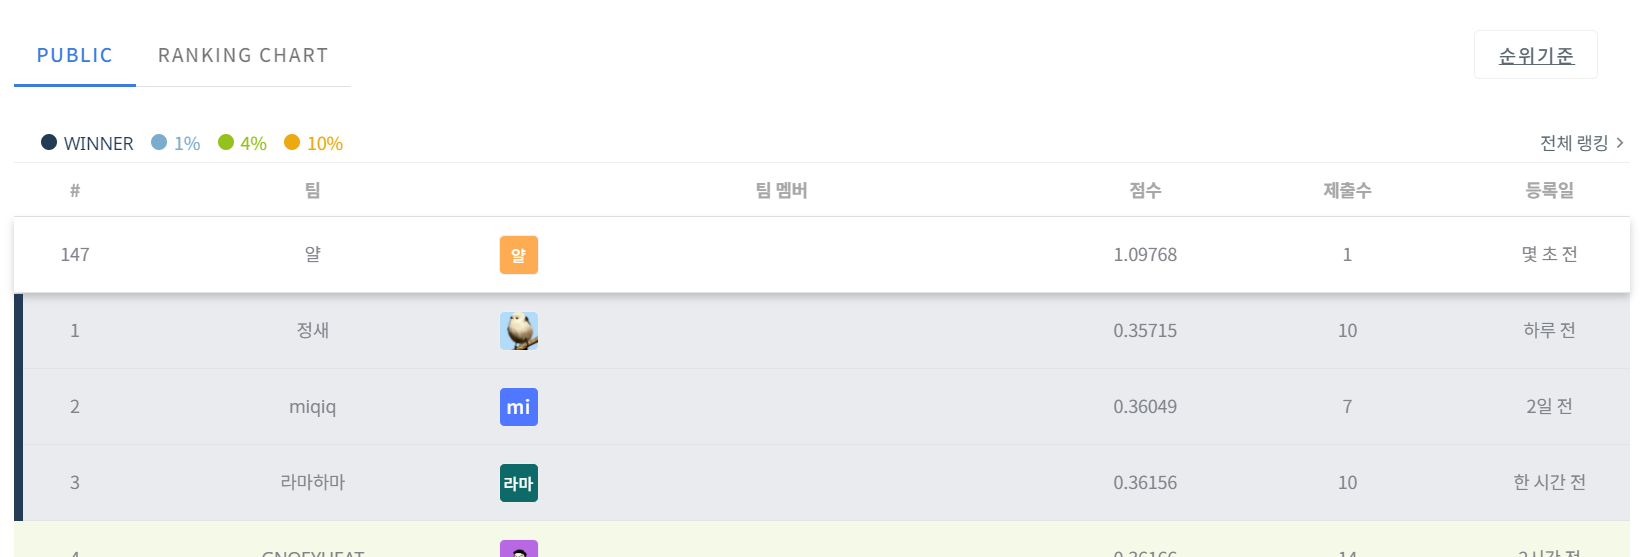

score: 1.0976854456

#### 모델링 2

- 단일 모델: LinearRegression 선형 회귀

  - 선형 회귀의 경우, 중요 범주형 피처들을 원-핫 인코딩으로 변환하는 것은 성능에 중요한 영향을 미칠 수 있다

In [ ]:
X_train_2 = X_train.copy()
y_train_2 = y_train.copy()

In [ ]:
lr = LinearRegression()
lr.fit(X_train_2, y_train_2)

pred_2 = lr.predict(X_test)

In [ ]:
pred_2

array([ -80.79434694, -169.15894966, -269.98753967, ..., -206.21635544,
        -72.72459816, -120.01379312])

In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')
submission['풍속 (m/s)'] = pred_2
submission.head()

,ID,풍속 (m/s)
0,TEST_00000,-80.794347
1,TEST_00001,-169.158950
2,TEST_00002,-269.987540
3,TEST_00003,-41.664867
4,TEST_00004,-101.675632


In [ ]:
submission.to_csv('submission_2.csv', index=  False)

순위 더 떨어짐

#### 모델링 3

- Autogluon 이용

In [ ]:
X_train_3 = X_train.copy()
y_train_3 = y_train.copy()

In [ ]:
y_train_3.head(3)

0    0.959350
1    0.985817
2    0.548121
Name: 풍속 (m/s), dtype: float64

In [ ]:
!pip install autogluon

ERROR: Operation cancelled by user


In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
import autogluon.core as ag

In [ ]:
train_3 = pd.concat([X_train_3, y_train_3], axis=1)

In [ ]:
train_3.head(3)

,월,일,측정 시간대,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg),풍속 (m/s)
0,7,2,3,13.97,287.78,9.84,76.1,992.08,2.832036,12.16,1.572774,7.66,1198.06,155.6,0.959350
1,8,21,1,16.94,290.85,12.14,73.3,991.07,3.012098,14.17,1.818077,8.94,1183.67,177.0,0.985817
2,11,1,3,9.76,283.84,5.40,74.2,988.71,2.572612,8.98,1.415853,5.67,1213.22,146.2,0.548121


In [ ]:
train_3 = TabularDataset(train_3)
X_test = TabularDataset(X_test)

In [ ]:
predictor = TabularPredictor(label='풍속 (m/s)',
                             problem_type='regression',
                             eval_metric='mae').fit(train_3)

No path specified. Models will be saved in: "AutogluonModels/ag-20230727_044102/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230727_044102/"
AutoGluon Version:  0.8.2
Python Version:     3.10.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   83.38 GB / 115.66 GB (72.1%)
Train Data Rows:    36581
Train Data Columns: 14
Label Column: 풍속 (m/s)
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11037.04 MB
	Train Data (Original)  Memory Usage: 4.1 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatur

[1000]	valid_set's l1: 0.185561
[2000]	valid_set's l1: 0.169956
[3000]	valid_set's l1: 0.161669
[4000]	valid_set's l1: 0.156781
[5000]	valid_set's l1: 0.153135
[6000]	valid_set's l1: 0.150523
[7000]	valid_set's l1: 0.148405
[8000]	valid_set's l1: 0.146782
[9000]	valid_set's l1: 0.145277
[10000]	valid_set's l1: 0.144252


	-0.1443	 = Validation score   (-mean_absolute_error)
	23.19s	 = Training   runtime
	3.47s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l1: 0.165738
[2000]	valid_set's l1: 0.153494
[3000]	valid_set's l1: 0.148446
[4000]	valid_set's l1: 0.146113
[5000]	valid_set's l1: 0.144918
[6000]	valid_set's l1: 0.144045
[7000]	valid_set's l1: 0.143417
[8000]	valid_set's l1: 0.142826
[9000]	valid_set's l1: 0.142451
[10000]	valid_set's l1: 0.142113


	-0.1421	 = Validation score   (-mean_absolute_error)
	22.77s	 = Training   runtime
	1.8s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.1474	 = Validation score   (-mean_absolute_error)
	82.35s	 = Training   runtime
	0.26s	 = Validation runtime
Fitting model: CatBoost ...
	-0.1488	 = Validation score   (-mean_absolute_error)
	198.42s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.1369	 = Validation score   (-mean_absolute_error)
	17.56s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.192	 = Validation score   (-mean_absolute_error)
	43.3s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost ...
	-0.1462	 = Validation score   (-mean_absolute_error)
	31.06s	 = Training   runtime
	2.02s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.1612	 = Validation score   (-mean_absolute_error)
	303.16s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: Lig

[1000]	valid_set's l1: 0.149135
[2000]	valid_set's l1: 0.142361
[3000]	valid_set's l1: 0.140528
[4000]	valid_set's l1: 0.139625
[5000]	valid_set's l1: 0.139307
[6000]	valid_set's l1: 0.139291
[7000]	valid_set's l1: 0.139238
[8000]	valid_set's l1: 0.139199
[9000]	valid_set's l1: 0.139244
[10000]	valid_set's l1: 0.139256


	-0.1392	 = Validation score   (-mean_absolute_error)
	50.14s	 = Training   runtime
	3.15s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.1339	 = Validation score   (-mean_absolute_error)
	0.35s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 803.86s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230727_044102/")


In [ ]:
results = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -0.133898      10.692065  448.231814                0.000633           0.354889            2       True         12
1         ExtraTreesMSE  -0.136855       0.228944   17.556133                0.228944          17.556133            1       True          7
2         LightGBMLarge  -0.139178       3.153922   50.139374                3.153922          50.139374            1       True         11
3              LightGBM  -0.142110       1.797391   22.767510                1.797391          22.767510            1       True          4
4            LightGBMXT  -0.144250       3.472089   23.193653                3.472089          23.193653            1       True          3
5               XGBoost  -0.146177       2.021983   31.058183                2.021983          31.

In [ ]:
model_to_use = predictor.get_model_best()
model_to_use

'WeightedEnsemble_L2'

In [ ]:
model_to_use = predictor.get_model_best()
pred_3 = predictor.predict(X_test, model=model_to_use)

In [ ]:
pred_3

0        1.104405
1        0.666788
2        0.987389
3        0.856508
4        0.946609
           ...   
15673    1.534070
15674    1.046430
15675    0.792045
15676    1.166205
15677    0.713134
Name: 풍속 (m/s), Length: 15678, dtype: float32

In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')
submission['풍속 (m/s)'] = pred_3
submission.head()

,ID,풍속 (m/s)
0,TEST_00000,1.104405
1,TEST_00001,0.666788
2,TEST_00002,0.987389
3,TEST_00003,0.856508
4,TEST_00004,0.946609


In [ ]:
submission.to_csv('submission_3.csv', index=  False)

순위는 동일, 점수는 조금 더 오름

score: 1.078565696

#### 모델링 4

- 전처리 하기 전의 데이터로 AutoGluon 다시 수행

In [ ]:
train_4 = train.copy()

In [ ]:
train_4 = train_4.drop('ID', axis=1)

In [ ]:
train_4 = TabularDataset(train_4)
X_test = TabularDataset(X_test)

In [ ]:
predictor = TabularPredictor(label='풍속 (m/s)',
                             problem_type='regression',
                             eval_metric='mae').fit(train_4)

No path specified. Models will be saved in: "AutogluonModels/ag-20230727_052242/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230727_052242/"
AutoGluon Version:  0.8.2
Python Version:     3.10.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   80.75 GB / 115.66 GB (69.8%)
Train Data Rows:    36581
Train Data Columns: 14
Label Column: 풍속 (m/s)
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11856.0 MB
	Train Data (Original)  Memory Usage: 4.1 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeature

[1000]	valid_set's l1: 0.185561
[2000]	valid_set's l1: 0.169956
[3000]	valid_set's l1: 0.161669
[4000]	valid_set's l1: 0.156781
[5000]	valid_set's l1: 0.153135
[6000]	valid_set's l1: 0.150523
[7000]	valid_set's l1: 0.148405
[8000]	valid_set's l1: 0.146782
[9000]	valid_set's l1: 0.145277
[10000]	valid_set's l1: 0.144252


	-0.1443	 = Validation score   (-mean_absolute_error)
	26.92s	 = Training   runtime
	3.29s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l1: 0.165738
[2000]	valid_set's l1: 0.153494
[3000]	valid_set's l1: 0.148446
[4000]	valid_set's l1: 0.146113
[5000]	valid_set's l1: 0.144918
[6000]	valid_set's l1: 0.144045
[7000]	valid_set's l1: 0.143417
[8000]	valid_set's l1: 0.142826
[9000]	valid_set's l1: 0.142451
[10000]	valid_set's l1: 0.142113


	-0.1421	 = Validation score   (-mean_absolute_error)
	21.92s	 = Training   runtime
	1.61s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.1474	 = Validation score   (-mean_absolute_error)
	81.2s	 = Training   runtime
	0.26s	 = Validation runtime
Fitting model: CatBoost ...
	-0.1488	 = Validation score   (-mean_absolute_error)
	185.05s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.1369	 = Validation score   (-mean_absolute_error)
	17.4s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.192	 = Validation score   (-mean_absolute_error)
	38.44s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ...
	-0.1462	 = Validation score   (-mean_absolute_error)
	31.98s	 = Training   runtime
	0.8s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.1612	 = Validation score   (-mean_absolute_error)
	315.6s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: Light

[1000]	valid_set's l1: 0.149135
[2000]	valid_set's l1: 0.142361
[3000]	valid_set's l1: 0.140528
[4000]	valid_set's l1: 0.139625
[5000]	valid_set's l1: 0.139307
[6000]	valid_set's l1: 0.139291
[7000]	valid_set's l1: 0.139238
[8000]	valid_set's l1: 0.139199
[9000]	valid_set's l1: 0.139244
[10000]	valid_set's l1: 0.139256


	-0.1392	 = Validation score   (-mean_absolute_error)
	52.04s	 = Training   runtime
	3.15s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.1339	 = Validation score   (-mean_absolute_error)
	0.49s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 799.9s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230727_052242/")


In [ ]:
model_to_use = predictor.get_model_best()
model_to_use

'WeightedEnsemble_L2'

In [ ]:
model_to_use = predictor.get_model_best()
pred_4 = predictor.predict(X_test, model=model_to_use)

In [ ]:
pred_4

0        1.104405
1        0.666788
2        0.987389
3        0.856508
4        0.946609
           ...   
15673    1.534070
15674    1.046430
15675    0.792045
15676    1.166205
15677    0.713134
Name: 풍속 (m/s), Length: 15678, dtype: float32

In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')
submission['풍속 (m/s)'] = pred_4
submission.head()

,ID,풍속 (m/s)
0,TEST_00000,1.104405
1,TEST_00001,0.666788
2,TEST_00002,0.987389
3,TEST_00003,0.856508
4,TEST_00004,0.946609


In [ ]:
submission.to_csv('submission_4.csv', index=  False)

전처리 한 후 AutoGluon을 적용한 경우와 점수 동일함

'autogluon을 돌릴거면 굳이 전처리를 하지 않아도 된다' 정도만 배워가는 듯함

score: 1.078565696